## Base models

In this notebook we will use some regression models to our data WITHOUT any tuning and data preprocessing (except missing value filling, encoding and scaling). Results which we will receive will be our base results which we will try to upgrade in the next notebooks

We will use 4 baseline models. DummyRegressor, Linear Regression (OLS), Ridge regression, and RandomForest regression. But it doesn't mean that we will not use some other models in future

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib as mpl
import seaborn as sns
from IPython.core.display import HTML
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error

## Content

In [ ]:
data = pd.read_csv("data/train_without_nans.csv")
sub = pd.read_csv("data/test_without_nans.csv")

encoded_data = pd.read_csv("data/encoded_train.csv")
encoded_sub = pd.read_csv("data/encoded_test.csv")

scaled_data = pd.read_csv("data/scaled_train.csv")
scaled_sub = pd.read_csv("data/scaled_test.csv")

### Train/test split & scaling

In [ ]:
X = encoded_data.drop(["SalePrice"], axis=1)
y = encoded_data["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

continuous_columns = data.select_dtypes(exclude="object").drop(["SalePrice", "Id", "MSSubClass"], axis=1).columns.values

print(continuous_columns)

scaler = StandardScaler()

X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

real_y_train = y_train.copy()
real_y_test = y_test.copy()

y_train = np.log(y_train)
y_test = np.log(y_test)

X_train.shape

## DummyRegressor

In [ ]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor().fit(X_train, y_train)

train_pred = dummy_reg.predict(X_train)
test_pred = dummy_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))
print("."*40)
print("TRAIN RMSE", root_mean_squared_error(real_y_train, np.exp(train_pred)))
print("TEST RMSE", root_mean_squared_error(real_y_test, np.exp(test_pred)))

This will be our "dummy" baseline

## OLS

In [ ]:
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression().fit(X_train, y_train)

train_pred = lr_reg.predict(X_train)
test_pred = lr_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))

What we see? Abnormally large test error. Even when we used logarithmic scaling for the target which means our model must give us not large values. Let's check minimal and maximal predicted values for train and test

In [ ]:
print("MIN TRAIN PREDICTION", np.min(train_pred))
print("MIN TEST PREDICTION", np.min(test_pred))
print("MAX TRAIN PREDICTION", np.max(train_pred))
print("MAX TEST PREDICTION", np.max(test_pred))

Probably this is the problem of a strong overfitting. Let's check model's largest coefficients

In [ ]:
sorted_coef_idx = np.argsort(-np.abs(lr_reg.coef_))
coef = lr_reg.coef_[sorted_coef_idx]
for i in range(0, 10):
    print("{:.<025} {:< 010.4e}".format(X_train.columns[sorted_coef_idx[i]], coef[i]))

We have very large coefficients near some features. This can be the problem of high correlation between some features.
BUT we can handle this problem not only with deleting correlated features. Also we can use L1 and L2 regularization

## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X_train, y_train)

train_pred = ridge_reg.predict(X_train)
test_pred = ridge_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))
print("." * 35)
print("TRAIN RMSE", root_mean_squared_error(real_y_train, np.exp(train_pred)))
print("TEST RMSE", root_mean_squared_error(real_y_test, np.exp(test_pred)))

## RandomForest regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor().fit(X_train, y_train)

train_pred = rf_reg.predict(X_train)
test_pred = rf_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))
print("." * 35)
print("TRAIN RMSE", root_mean_squared_error(real_y_train, np.exp(train_pred)))
print("TEST RMSE", root_mean_squared_error(real_y_test, np.exp(test_pred)))

## Submission to kaggle

Before submission we will use the whole train dataset for training. Because of the fact that ols gives us overflow we will submit onlu ridge and random_forest

In [ ]:
scaled_X = scaled_data.drop(["SalePrice"], axis=1)
scaled_y = scaled_data["SalePrice"]


dummy_reg = dummy_reg.fit(scaled_X, scaled_y)
dummy_sub = pd.Series(np.exp(dummy_reg.predict(scaled_sub)))
dummy_sub_df = pd.DataFrame()
dummy_sub_df["Id"] = sub["Id"]
dummy_sub_df["SalePrice"] = dummy_sub

dummy_sub_df.to_csv("models/baseline/dummy.csv", index=False)

ridge_reg = ridge_reg.fit(scaled_X, scaled_y)
ridge_sub = pd.Series(np.exp(ridge_reg.predict(scaled_sub)))
ridge_sub_df = pd.DataFrame()
ridge_sub_df["Id"] = sub["Id"]
ridge_sub_df["SalePrice"] = ridge_sub

ridge_sub_df.to_csv("models/baseline/linear_ridge.csv", index=False)


rf_reg = rf_reg.fit(scaled_X, scaled_y)
rf_sub = pd.Series(np.exp(rf_reg.predict(scaled_sub)))
rf_sub_df = pd.DataFrame()
rf_sub_df["Id"] = sub["Id"]
rf_sub_df["SalePrice"] = rf_sub

rf_sub_df.to_csv("models/baseline/random_forest.csv", index=False)

We received the next results on Kaggle submission for Ridge regression and Random Forest regression:

**Ridge** &ndash; **0.14027**

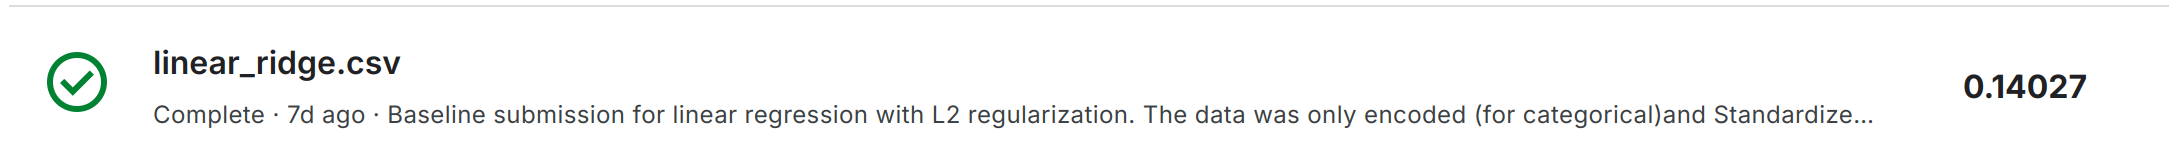  

**RandomForest** &ndash; **0.14401**

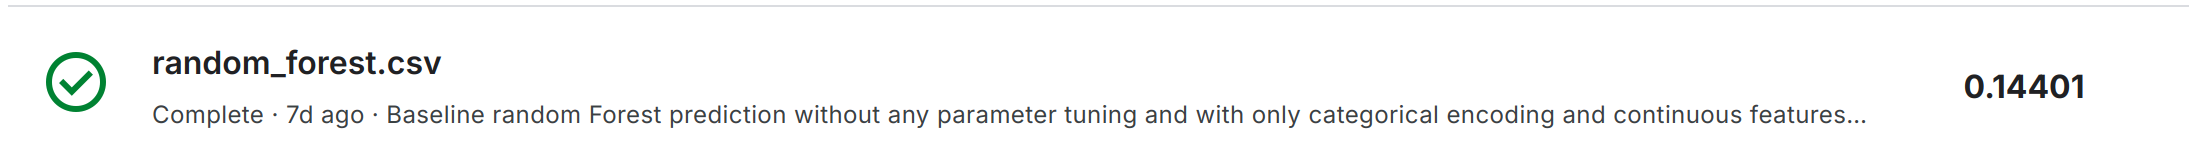